# Решение

## Подготовка

Импортируем необходимые для начала работы библиотеки

In [1]:
import os
import numpy as np
import pandas as pd

Определяем папку, где находятся данные

In [2]:
data_dir = os.path.join('..', 'data')

Загружаем данные

In [3]:
users_df = pd.read_csv(os.path.join(data_dir, 'users.tsv'), sep='\t')
history_df = pd.read_csv(os.path.join(data_dir, 'history.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(data_dir, 'validate.tsv'), sep='\t')
validate_answers_df = pd.read_csv(os.path.join(data_dir, 'validate_answers.tsv'), sep='\t')

## Работа с "Историей"

Чтобы удобнее было перезапускать частично, периодически будем копировать датафреймы

In [4]:
history = history_df.copy()

Проходимся по датафрейму и агрегируем необходимые нам данные

Можно заменить на вызовы методов датафреймов для необходимых агрегаций, но мне показалось, что так может быть быстрее

Основные показатели которые нам нужны - набор выигравших cpm для каждого пользователя и распределение пользователей по площадкам 

In [5]:
user_cpms = {}
publisher_users = {}

for index, row in history.iterrows():
    user_id = str(int(row['user_id']))
    publisher = str(int(row['publisher']))
    cpm = row['cpm']

    if user_id not in user_cpms:
        user_cpms[user_id] = []
    user_cpms[user_id].append(cpm)

    if publisher not in publisher_users:
        publisher_users[publisher] = set()
    publisher_users[publisher].add(user_id)

## Работа с "Рекламой"

Аналогично копируем датафрейм

In [6]:
ads = validate_df.copy()

Из анализа мы определили, что есть "пиковые часы" 8-22, мне кажется их можно использовать для создания фичей

In [7]:
def peak_hours(hour_start, hour_end):
    peak_hours_count = 0
    for i in range(hour_start, hour_end + 1):
        hour_norm = i % 24
        if 8 <= hour_norm <= 22:
            peak_hours_count += 1
    return peak_hours_count

Создаем фичи  
В принципе тут можно без комментариев понять по названиям

In [8]:
ads['publisher_size'] = ads['publishers'].apply(lambda publishers: len(publishers.split(',')))

ads['peak_hours'] = ads.apply(lambda row: peak_hours(row['hour_start'], row['hour_end']), axis=1)

ads['cpm_x_peak_hours'] = ads['cpm'] * ads['peak_hours']

ads['publisher_size_x_peak_hours'] = ads['publisher_size'] * ads['peak_hours']

Далее мы начинаем обходить для каждого рекламного объявления пользователей, которые в нем указаны и создаем фичи на их основе

Как показала практика это одни из самых значимых фичей

`users_power` - это показатель того, сколько человек смотрит рекламы  
не придумал более хорошего названия

In [9]:
def process_ad_users(user_ids, user_cpms):
    users = user_ids.split(',')
    counts = []
    cpms = []
    for user in users:
        if user in user_cpms:
            counts.append(len(user_cpms[user]))
            cpms.extend(user_cpms[user])

    return sum(counts), np.mean(counts), np.mean(cpms)

In [10]:
ads[['users_power', 'mean_users_power', 'mean_cpm_per_users']] = ads['user_ids'].apply(
    lambda user_ids: process_ad_users(user_ids, user_cpms)
).apply(pd.Series)

Здесь примерно то же самое, только обходим по площадкам

In [11]:
def process_ad_publishers(publisher_ids, publisher_users):
    publishers = publisher_ids.split(',')
    counts = []
    for publisher in publishers:
        if publisher in publisher_users:
            counts.append(len(publisher_users[publisher]))

    return sum(counts), np.mean(counts)

In [12]:
ads[['active_users_in_publishers', 'mean_active_users_in_publishers']] = ads['publishers'].apply(
    lambda publisher_ids: process_ad_publishers(publisher_ids, publisher_users)
).apply(pd.Series)

## Завершение обработки данных

Далее будем приводить всё к виду, в котором будет удобно скармливать данные модели

In [13]:
features = ads.copy()

Тут удаляем совсем неподходящие (по типу) колонки

In [14]:
features = features.drop(columns=['user_ids', 'publishers'])

Тут удаляем уже те, которые нам не нравятся (по влиянию на модель)

In [15]:
features = features.drop(columns=['hour_start', 'hour_end'])

Вот что у нас получилось по составу колонок

In [16]:
features.columns

Index(['cpm', 'audience_size', 'publisher_size', 'peak_hours',
       'cpm_x_peak_hours', 'publisher_size_x_peak_hours', 'users_power',
       'mean_users_power', 'mean_cpm_per_users', 'active_users_in_publishers',
       'mean_active_users_in_publishers'],
      dtype='object')

Посмотрим на матрицу корреляций

In [17]:
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm')

,cpm,audience_size,publisher_size,peak_hours,cpm_x_peak_hours,publisher_size_x_peak_hours,users_power,mean_users_power,mean_cpm_per_users,active_users_in_publishers,mean_active_users_in_publishers
cpm,1.000000,-0.000887,0.026065,-0.012519,0.414271,0.008217,0.010567,0.002696,0.037102,0.017504,-0.015117
audience_size,-0.000887,1.000000,0.025797,0.014840,0.022473,0.014297,0.521994,0.048228,-0.002968,-0.020482,-0.050152
publisher_size,0.026065,0.025797,1.000000,-0.037479,-0.000732,0.278517,-0.020791,-0.046162,0.028412,0.517861,-0.364333
peak_hours,-0.012519,0.014840,-0.037479,1.000000,0.738799,0.874611,0.039895,0.060199,0.008698,-0.025915,0.005092
cpm_x_peak_hours,0.414271,0.022473,-0.000732,0.738799,1.000000,0.668658,0.035554,0.057024,-0.000511,0.003795,0.012754
publisher_size_x_peak_hours,0.008217,0.014297,0.278517,0.874611,0.668658,1.000000,0.031866,0.046068,0.019122,0.138881,-0.103672
users_power,0.010567,0.521994,-0.020791,0.039895,0.035554,0.031866,1.000000,0.778316,-0.212048,-0.023681,-0.026245
mean_users_power,0.002696,0.048228,-0.046162,0.060199,0.057024,0.046068,0.778316,1.000000,-0.318550,-0.008926,0.026776
mean_cpm_per_users,0.037102,-0.002968,0.028412,0.008698,-0.000511,0.019122,-0.212048,-0.318550,1.000000,-0.016837,-0.045344
active_users_in_publishers,0.017504,-0.020482,0.517861,-0.025915,0.003795,0.138881,-0.023681,-0.008926,-0.016837,1.000000,0.493366


Видно, что некоторые признаки сильно коррелируют, но я не стал их убирать пока, потому что они всё равно полезны для метрики

In [18]:
target = validate_answers_df.copy()

Делим на train и test

In [19]:
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.33, random_state=42)

## Работа с моделью

Используем CatBoostRegressor, потому что модель дает неплохой результат сходу (лучше чем у xgboost и GradientBoostingRegressor)

In [20]:
from catboost import CatBoostRegressor

X_train1, X_test1, y_train1, y_test1 = features_train, features_test, target_train['at_least_one'], target_test['at_least_one']

model1 = CatBoostRegressor(silent=True)
model1.fit(X_train1, y_train1)

В будущем конечно надо оптимизировать гиперпараметры

Посмотрим на значимость фичей  
Для этого будем использовать библиотеку SHAP

In [21]:
import shap

Инициализируем библиотеку

In [22]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer(X_train1)

Выведем фичи и их значимость

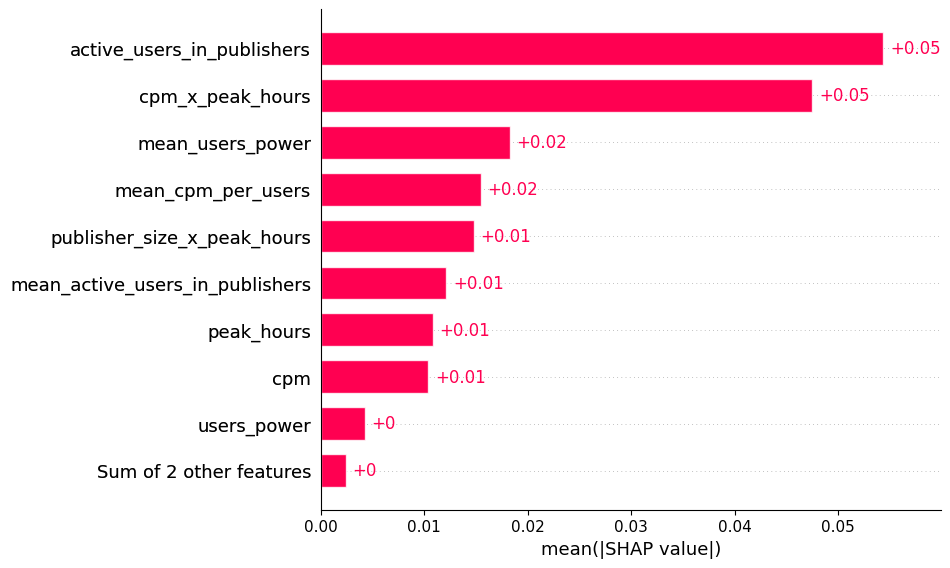

In [23]:
shap.plots.bar(shap_values)

Также выведем heatmap фич, чтобы увидеть как фичи описывают данные в совокупности (порядок семплов определен библиотекой на основе объясняемой схожести, т.е. библиотка применяет иерархическую кластеризацию для того, чтобы наиболее "объясняемые" с помощью наших фич были рядом друг с другом)

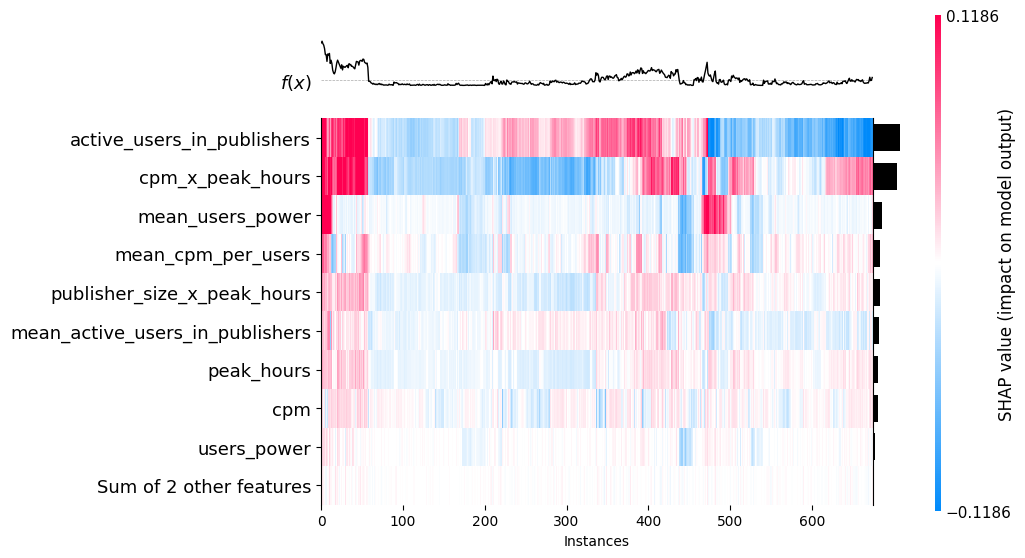

In [24]:
shap.plots.heatmap(shap_values);

Можно убрать малозначимые и добавить каких-нибудь еще интересных

Я пробовал перемножать и делить базовые фичи (cpm, duration, sizes), но там ничего супер полезного не было

Функцию написал для того, чтобы в будущем легче было сравнивать модели, но пока не пригодилось

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")

Посчитаем метрику на test

In [26]:
y_true1 = np.array(y_test1)
y_pred1 = model1.predict(X_test1)

print_metrics(y_true1, y_pred1)

MAE: 0.0193
MSE: 0.0010
RMSE: 0.0309
R2: 0.9509


Неплохо  
У меня получалось лучше, но там было в 2 раза больше малополезных фичей, а результат не сильно отличался  

График распределения значений

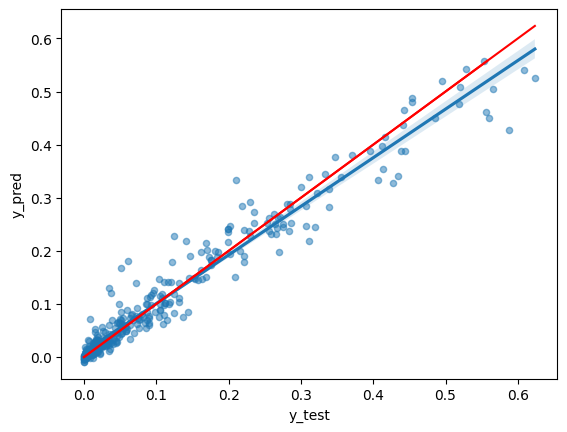

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

result1 = pd.DataFrame()
result1['y_test'] = y_test1
result1['y_pred'] = y_pred1

sns.regplot(data=result1, x='y_test', y='y_pred', scatter_kws={"s": 20, "alpha": 0.5})

x = np.linspace(0, result1.max(), 100)
plt.plot(x, x, color="red");

Видно, что есть некоторая ошибка (расхождение между линиями), но в целом получается неплохо

Но это пока только один таргет, а нам надо еще 2

Во время анализа данных была выявлена сильная корреляция между таргетами  
Воспользуемся этим

Из всех опробованных моделей (GradientBoostingRegressor, CatBoostRegressor, LinearRegression) без оптимизации гиперпараметров лучше с задачей справляется GradientBoostingRegressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

Попробуем обучить (пока независимо) модели для регрессии двух оставшихся таргетов

In [29]:
X_train2, X_test2, y_train2, y_test2 = target_train[['at_least_one']], target_test[['at_least_one']], target_train['at_least_two'], target_test['at_least_two']

model2 = GradientBoostingRegressor()
model2.fit(X_train2, y_train2)

y_pred2 = model2.predict(X_test2)

print_metrics(y_test2, y_pred2)

MAE: 0.0144
MSE: 0.0007
RMSE: 0.0267
R2: 0.9394


In [30]:
X_train3, X_test3, y_train3, y_test3 = target_train[['at_least_two']], target_test[['at_least_two']], target_train['at_least_three'], target_test['at_least_three']

model3 = GradientBoostingRegressor()
model3.fit(X_train3, y_train3)

y_pred3 = model3.predict(X_test3)

print_metrics(y_test3, y_pred3)

MAE: 0.0066
MSE: 0.0002
RMSE: 0.0132
R2: 0.9779


В целом получаются неплохие метрики

Теперь попробуем объединить модели в одну и посмотрим результат сразу на предложенной метрике

In [31]:
from metrics import get_smoothed_mean_log_accuracy_ratio

В baseline (все нули) метрика равна

In [32]:
baseline = pd.read_csv(os.path.join(data_dir, 'baseline.tsv'), sep='\t')
baseline_train, baseline_test = train_test_split(baseline, test_size=0.33)
get_smoothed_mean_log_accuracy_ratio(target_test, baseline_test)

397.79

Нам надо сделать лучше)

У модели есть параметр, который отвечает за то будет ли каждая "следующая" суб-модель обучаться на результатах прошлой модели или будем обучать их независимо

In [33]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import GradientBoostingRegressor

class VKAdsRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, train_independently: bool = False):
        self.train_independently = train_independently
        self.model1 = CatBoostRegressor(silent=True)
        self.model2 = GradientBoostingRegressor()
        self.model3 = GradientBoostingRegressor()

    def _wrap_to_df(self, name, data):
        df = pd.DataFrame()
        df[name] = data
        return df

    def fit(self, X, y):
        self.model1.fit(X, y['at_least_one'])
        
        if self.train_independently:
            self.model2.fit(y[['at_least_one']].to_numpy(), y['at_least_two'])
            self.model3.fit(y[['at_least_two']].to_numpy(), y['at_least_three'])
        else:
            output1 = np.clip(self.model1.predict(X), a_min=0, a_max=1).reshape(-1, 1)
            self.model2.fit(output1, y['at_least_two'])

            output2 = self.model2.predict(output1).reshape(-1, 1)
            self.model3.fit(output2, y['at_least_three'])

        return self

    def predict(self, X):
        output1 = np.clip(self.model1.predict(X), a_min=0, a_max=1)
        output2 = self.model2.predict(output1.reshape(-1, 1))
        output3 = self.model3.predict(output2.reshape(-1, 1))

        output = pd.DataFrame()
        output['at_least_one'] = output1
        output['at_least_two'] = output2
        output['at_least_three'] = output3
        output = output.set_index(X.index)
        
        return output

Для начала попробуем обучать независимо

In [34]:
model = VKAdsRegressor(train_independently=True)
model.fit(features_train, target_train)

target_pred = model.predict(features_test)

get_smoothed_mean_log_accuracy_ratio(target_test, target_pred)

49.28

А теперь попробуем во время обучения постараться учесть ошибки модели и каждую следующую суб-модель будем обучать, используя данные предыдущей суб-модели

In [35]:
model = VKAdsRegressor(train_independently=False)
model.fit(features_train, target_train)

target_pred = model.predict(features_test)

get_smoothed_mean_log_accuracy_ratio(target_test, target_pred)

49.86

Немного странно, но получилось так что независимое обучение суб-моделей дало лучший результат, но возможно при оптимизации гиперпараметров модели всё изменится

В итоге получили результат ~50 по предложенной метрике, что однозначно лучше чем baseline)